1. IMPORT CÁC THƯ VIỆN CẦN THIẾT

In [16]:
import os
import numpy as np
import cv2

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_uniform

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

2. TIỀN XỬ LÝ DỮ LIỆU:

In [17]:
# Load dữ liệu
def load_dataset_from_dir(data_dir, img_size=(32,32)):
    X, y = [], []
    classes = sorted(d for d in os.listdir(data_dir)
                     if os.path.isdir(os.path.join(data_dir, d)))
    label_map = {cls:i for i,cls in enumerate(classes)}

    for cls in classes:
        cls_dir = os.path.join(data_dir, cls)
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith(('.jpg','.jpeg','.png')):
                path = os.path.join(cls_dir, fname)
                img = cv2.imread(path, cv2.IMREAD_COLOR)
                if img is None:
                    continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)                   
                img = img.astype(np.float16) / 255.0              
                X.append(img)
                y.append(cls)                                     

    X = np.array(X)                                         
    y = np.array(y)

    return X, y, label_map


# Đọc dữ liệu
dataset_path_train = '/kaggle/input/cus-hand-written/hand_written_digit/train'
dataset_path_test = '/kaggle/input/cus-hand-written/hand_written_digit/test'

X_train, y_train, label_map_train = load_dataset_from_dir(dataset_path_train, img_size=(32,32))
X_test, y_test, label_map_test = load_dataset_from_dir(dataset_path_test, img_size=(32,32))
print(f"Tổng số ảnh train: {len(X_train)}")
print(f"Tổng số ảnh test: {len(X_test)}")

Tổng số ảnh train: 3482
Tổng số ảnh test: 778


In [18]:
# Encode nhãn và chia dữ liệu train/test
le = LabelEncoder()
y_train_num = le.fit_transform(y_train)
y_test_num = le.fit_transform(y_test)
num_classes = len(le.classes_)

print(y_train_num)

[0 0 0 ... 9 9 9]


In [19]:
# Chia tập train-valid tỉ lệ 8-2
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train_num, test_size=0.2, random_state=42, stratify=y_train_num
)

print(f"Số ảnh TRAIN: {len(X_train_sub)}")
print(f"Số ảnh VALIDATION: {len(X_val)}")
print(f"Tổng số ảnh test: {len(X_test)}")

Số ảnh TRAIN: 2785
Số ảnh VALIDATION: 697
Tổng số ảnh test: 778


In [20]:
# One-hot encode Y
Y_train = to_categorical(y_train_sub, num_classes)
Y_val = to_categorical(y_val, num_classes)
Y_test = to_categorical(y_test, num_classes)

print(Y_train)
print(Y_val)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


3. XÂY DỰNG MÔ HÌNH

In [6]:
# Load base ResNet50
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Đóng băng các lớp của ResNet50
for layer in resnet.layers:
    layer.trainable = False

# Thêm các lớp mới cho bài toán phân loại
x = GlobalAveragePooling2D()(resnet.output)
x = Flatten()(x)
output = Dense(num_classes, activation='softmax', name='fc' + str(num_classes),
               kernel_initializer=glorot_uniform(seed=0))(x)

I0000 00:00:1751262307.518273      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751262307.519009      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
# Tạo mô hình mới từ VGG16 + các lớp phân loại mới
model = Model(inputs=resnet.input, outputs=output)
model.summary()

# Compile mô hình
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Callback
callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

4. HUẤN LUYỆN MÔ HÌNH CNN

In [8]:
# training
H = model.fit(
    X_train_sub, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=32,
    epochs=100,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/100


I0000 00:00:1751262321.977997      65 service.cc:148] XLA service 0x795270001fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751262321.978605      65 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751262321.978632      65 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751262323.524189      65 cuda_dnn.cc:529] Loaded cuDNN version 90300


 21/107 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0712 - loss: 2.9429

I0000 00:00:1751262326.595368      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


107/107 ━━━━━━━━━━━━━━━━━━━━ 27s 114ms/step - accuracy: 0.0890 - loss: 2.5558 - val_accuracy: 0.1012 - val_loss: 2.4011
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1273 - loss: 2.3356 - val_accuracy: 0.1176 - val_loss: 2.4057
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1244 - loss: 2.3304 - val_accuracy: 0.1471 - val_loss: 2.2938
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1453 - loss: 2.2881 - val_accuracy: 0.1376 - val_loss: 2.2943
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.1393 - loss: 2.3045 - val_accuracy: 0.1059 - val_loss: 2.3407
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1371 - loss: 2.3193 - val_accuracy: 0.1412 - val_loss: 2.2912
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1385 - loss: 2.2925 - val_accuracy: 0.1435 - val_loss: 2.2909
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.1381 - loss: 2.3028 - val_accura

In [9]:
# save model
os.makedirs("/kaggle/working", exist_ok=True)
model.save("/kaggle/working/vgg16_finetuned_model.keras")

5. VISUALIZATION

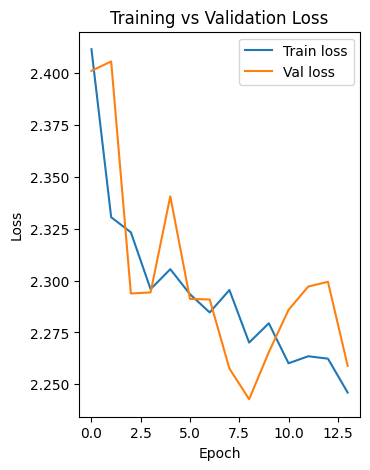

<function matplotlib.pyplot.show(close=None, block=None)>

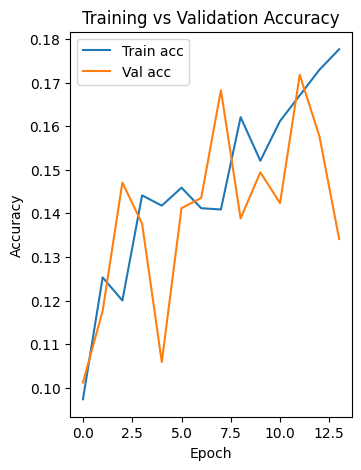

In [10]:
# 12. Vẽ đồ thị loss và accuracy của training & validation
# Loss
plt.figure(figsize=(8,5))
plt.subplot(1, 2, 2)
plt.plot(H.history['loss'], label='Train loss')
plt.plot(H.history['val_loss'], label='Val loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure(figsize=(8,5))
plt.subplot(1, 2, 1)
plt.plot(H.history['accuracy'], label='Train acc')
plt.plot(H.history['val_accuracy'], label='Val acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show


6. Đánh giá trên tập test

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

model = load_model('/kaggle/working/vgg16_finetuned_model.keras')

# Dự đoán nhãn trên tập test
y_test_pred_prob = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

# In classification report
print("=== Classification Report trên tập TEST ===")
print(classification_report(y_test_num, y_test_pred, target_names=le.classes_))

25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step
=== Classification Report trên tập TEST ===
              precision    recall  f1-score   support

           0       0.32      0.31      0.32        77
           1       0.00      0.00      0.00        77
           2       0.20      0.03      0.05        78
           3       0.00      0.00      0.00        80
           4       0.10      0.87      0.18        75
           5       0.10      0.03      0.04        76
           6       0.00      0.00      0.00        78
           7       0.50      0.08      0.13        79
           8       0.50      0.10      0.17        79
           9       0.00      0.00      0.00        79

    accuracy                           0.14       778
   macro avg       0.17      0.14      0.09       778
weighted avg       0.17      0.14      0.09       778



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


7. Dự đoán trên tập dữ liệu Predict

In [11]:
import os
import cv2
import numpy as np

model = load_model('/kaggle/working/vgg16_finetuned_model.keras')

# Hàm dự đoán và lưu kết quả
def predict_and_save_results(model, data_dir, img_size=(32,32)):
    X, filenames = [], []
    
    # Kiểm tra lại img_size có đúng định dạng không
    if not isinstance(img_size, tuple) or len(img_size) != 2:
        raise ValueError(f"img_size phải là một tuple có 2 phần tử. Hiện tại là {img_size}")
    
    # Duyệt qua tất cả các file trong thư mục dữ liệu
    for fname in os.listdir(data_dir):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):  # Lọc các ảnh
            path = os.path.join(data_dir, fname)
            img = cv2.imread(path, cv2.IMREAD_COLOR)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Đổi sang RGB
            
            # Resize hình ảnh về kích thước 32x32
            img = cv2.resize(img, img_size)  # Resize ảnh
            img = img.astype(np.float16) / 255.0  # Chuẩn hóa ảnh
            X.append(img)
            filenames.append(fname)
    
    # Chuyển X thành mảng numpy
    X = np.array(X)
    
    # Dự đoán nhãn
    predictions = model.predict(X)
    predicted_classes = np.argmax(predictions, axis=1)  # Lấy nhãn có xác suất cao nhất

    # Lưu kết quả vào file CSV với định dạng tên file và nhãn
    result_file = '/kaggle/working/predictions.csv'
    with open(result_file, 'w') as f:
        for fname, predicted_class in zip(filenames, predicted_classes):
            # Đảm bảo giữ nguyên tên file đầy đủ (bao gồm phần mở rộng)
            f.write(f"{fname},{predicted_class}\n")
    
    print(f"Results saved to {result_file}")

# Dự đoán cho bộ test
dataset_path_test = '/kaggle/input/hand-written'
predict_and_save_results(model, dataset_path_test)

305/305 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step
Results saved to /kaggle/working/predictions.csv
